In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from PIL import Image, ImageEnhance


In [2]:
# setting the directory of our dataset
DATASET_DIR = "for_james/"

In [3]:
# class PreprocessImage():

#     def __init__(self, img, contrast=True):
#         self.img = img 
#         self.contrast = contrast
        
#     def left_align(self):
#         """
#         Determines whether the breast is aligned to the right or left side of the image
#         by measuring the mean gray level of either half. Flips the image to the left if it
#         is right-aligned.

#         Parameters:
#             img: The numpy array representing the image.

#         Assumptions:
#             - The half of the image on which the majority of the breast region lies has a higher mean than the othe half
#             - The input image is LCC view

#         Returns:
#             numpy array with the left aligned image.
#         """
#         pixels = np.asarray(self.img)
#         if np.mean(pixels[0:256, 0:128]) < np.mean(pixels[0:256, 128:256]):
#             self.img = pixels[:, ::-1]
#             return
#         self.img = pixels 

#     def perform_contrast(self):
#         """
#         Adjusts the contrast of the given image by a specific factor.

#         Parameters:
#             img: PIL image to be adjusted
#         Assumptions:
#             None
#         Returns:
#             PIL image with the contrast adjusted.
#         """
#         enhancer = ImageEnhance.Contrast(self.img)
#         factor = 1#increase contrast
#         self.img = enhancer.enhance(factor)

#     def remove_bar(self):
#         """
#         Finds the width of the black bar on the left of the image by checking iteratively until a pixel whose value is greater than
#         the mean of the grey values of the image is found. Then crops the image to remove the bar.

#         Parameters:
#             img: numpy array of the image to be adjusted
#         Assumptions:
#             - There is no blank space at the top of the image (not even 1px)
#             - The image is left-aligned
#             - The black bar is darker than the mean grey level of the image, and the pectoral muscle region is brighter.
#         Returns:
#             Numpy array of the cropped image
#         """
#         width = 0 
#         while self.img[1, width] <= np.mean(self.img):
#             width += 1
#         self.img = self.img[:, width:256]

#     def preprocess_image(self):
#         """
#         Combines all of the above preprocessing steps together on a given image.

#         Parameters:
#             img: PIL image to be adjusted
#         Assumptions:
#             - There is no blank space at the top of the image (not even 1px).
#             - We want to optimize for speed over precision.
#             - The input image is LCC view.
#             - The half of the image on which the majority of the breast region lies has a higher mean than the othe half.

#         Returns:
#             PIL image ready for the level set algorithm.
#         """
#         if self.contrast:
#             self.perform_contrast()
#         self.img = self.img.resize((256,256))
#         self.left_align()
#         self.remove_bar()
#         img = np.interp(self.img, [np.min(self.img), np.max(self.img)], [0, 255])
#         return img

In [4]:
#class pour une pile
class Stack():
    def __init__(self):
        self.item = []
        self.obj=[]
    def push(self, value):
        self.item.append(value)

    def pop(self):
        return self.item.pop()

    def size(self):
        return len(self.item)

    def isEmpty(self):
        return self.size() == 0

    def clear(self):
        self.item = []

In [5]:
class regionGrow():
  
    def __init__(self,im_path,th):
        self.readImage(im_path)
        self.h, self.w,_ =  self.im.shape
        self.passedBy = np.zeros((self.h,self.w), np.double)
        self.currentRegion = 0
        self.iterations=0
        self.SEGS=np.zeros((self.h,self.w,3), dtype='uint8')
        self.stack = Stack()
        self.thresh=float(th)
        
    def readImage(self, img_path):
        self.im = cv2.imread(img_path,1)
    
    def getNeighbour(self, x0, y0):
        neighbour = []
        for i in (-1,0,1):
            for j in (-1,0,1):
                if (i,j) == (0,0): 
                    continue
                x = x0+i
                y = y0+j
                if self.limit(x,y):
                    neighbour.append((x,y))
        return neighbour
    
    def ApplyRegionGrow(self):
#         randomseeds=[[self.h/2,self.w/2],
#             [self.h/3,self.w/3],[2*self.h/3,self.w/3],[self.h/3-10,self.w/3],
#             [self.h/3,2*self.w/3],[2*self.h/3,2*self.w/3],[self.h/3-10,2*self.w/3],
#             [self.h/3,self.w-10],[2*self.h/3,self.w-10],[self.h/3-10,self.w-10]
#                     ]
#         np.random.shuffle(randomseeds)
        for x0 in range (self.h):
            for y0 in range (self.w):
         
                if self.passedBy[x0,y0] == 0 and (int(self.im[x0,y0,0])*int(self.im[x0,y0,1])*int(self.im[x0,y0,2]) > 0) :  
                    self.currentRegion += 1
                    self.passedBy[x0,y0] = self.currentRegion
                    self.stack.push((x0,y0))
                    self.prev_region_count=0
                    while not self.stack.isEmpty():
                        x,y = self.stack.pop()
                        self.BFS(x,y)
                        self.iterations+=1
                    if(self.PassedAll()):
                        break
                    
                    if(self.prev_region_count<8*8):     
                        self.passedBy[self.passedBy==self.currentRegion]=0
                        x0=random.randint(x0-4,x0+4)
                        y0=random.randint(y0-4,y0+4)
                        x0=max(0,x0)
                        y0=max(0,y0)
                        x0=min(x0,self.h-1)
                        y0=min(y0,self.w-1)
                        self.currentRegion-=1
        
        pectoral_muscle_region = []
        
        for i in range(0,self.h):
            for j in range (0,self.w):
                val = self.passedBy[i][j]
                if(val==0):
                    self.SEGS[i][j]=255,255,255
                else:
                    if (val == 1):
                        self.SEGS[i][j]=0,0,0
                        pectoral_muscle_region.append((i,j)) 
                    else:
                        self.SEGS[i][j]=val*35, val*90, val*30
                    
        if(self.iterations>200000):
            print("Max Iterations")
        print("Iterations : "+str(self.iterations))
#         cv2.imshow('image window', self.SEGS)
        return pectoral_muscle_region
#         plt.imshow(self.SEGS)
#         plt.show()
#         cv2.imshow(self.SEGS)
        # cv2.destroyAllWindows()
        
    def BFS(self, x0,y0):
        regionNum = self.passedBy[x0,y0]
        elems=[]
        elems.append((int(self.im[x0,y0,0])+int(self.im[x0,y0,1])+int(self.im[x0,y0,2]))/3)
        var=self.thresh
        neighbours=self.getNeighbour(x0,y0) 
        for x,y in neighbours:
            if self.passedBy[x,y] == 0 and self.distance(x,y,x0,y0)<var:
                if(self.PassedAll()):
                    break;
                self.passedBy[x,y] = regionNum
                self.stack.push((x,y))
                elems.append((int(self.im[x,y,0])+int(self.im[x,y,1])+int(self.im[x,y,2]))/3)
                var=np.var(elems)
                self.prev_region_count+=1
            var=max(var,self.thresh)
    
    def PassedAll(self):
        return self.iterations>200000 or np.count_nonzero(self.passedBy > 0) == self.w*self.h

    def limit(self, x,y):
        return  0<=x<self.h and 0<=y<self.w
    
    def distance(self,x,y,x0,y0):
        return ((int(self.im[x,y,0])-int(self.im[x0,y0,0]))**2+(int(self.im[x,y,1])-int(self.im[x0,y0,1]))**2+(int(self.im[x,y,2])-int(self.im[x0,y0,2]))**2)**0.5

In [6]:
def read_this(image_file, gray_scale=False):
    image_src = cv2.imread(image_file)
    if gray_scale:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2GRAY)
    else:
        image_src = cv2.cvtColor(image_src, cv2.COLOR_BGR2RGB)
    return image_src

def equalize_this(image_file, with_plot=False, gray_scale=False):
    image_src = read_this(image_file=image_file, gray_scale=gray_scale)
    if not gray_scale:
        r_image, g_image, b_image = cv2.split(image_src)

        r_image_eq = cv2.equalizeHist(r_image)
        g_image_eq = cv2.equalizeHist(g_image)
        b_image_eq = cv2.equalizeHist(b_image)

        image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
        cmap_val = None
    else:
        image_eq = cv2.equalizeHist(image_src)
        cmap_val = 'gray'

    if with_plot:
        fig = plt.figure(figsize=(10, 20))

        ax1 = fig.add_subplot(2, 2, 1)
        ax1.axis("off")
        ax1.title.set_text('Original')
        ax2 = fig.add_subplot(2, 2, 2)
        ax2.axis("off")
        ax2.title.set_text("Equalized")

        ax1.imshow(image_src, cmap=cmap_val)
        ax2.imshow(image_eq, cmap=cmap_val)
        return True
    return image_eq

In [7]:
# class regionGrow():
  
#     def __init__(self,im_path,th):
#         self.readImage(im_path)
#         self.h, self.w =  self.im.shape
#         self.passedBy = np.zeros((self.h,self.w), np.double)
#         self.currentRegion = 0
#         self.iterations=0
#         self.SEGS=np.zeros((self.h,self.w, 3), dtype='uint8')
#         self.stack = Stack()
#         self.thresh=float(th)
        
#     def readImage(self, img_path):
#         self.im = cv2.imread(img_path,0)
    
#     def getNeighbour(self, x0, y0):
#         neighbour = []
#         for i in (-1,0,1):
#             for j in (-1,0,1):
#                 if (i,j) == (0,0): 
#                     continue
#                 x = x0+i
#                 y = y0+j
#                 if self.limit(x,y):
#                     neighbour.append((x,y))
#         return neighbour
    
#     def ApplyRegionGrow(self):
        
#         randomseeds=[[self.h/2,self.w/2],
#             [self.h/3,self.w/3],[2*self.h/3,self.w/3],[self.h/3-10,self.w/3],
#             [self.h/3,2*self.w/3],[2*self.h/3,2*self.w/3],[self.h/3-10,2*self.w/3],
#             [self.h/3,self.w-10],[2*self.h/3,self.w-10],[self.h/3-10,self.w-10]
#                     ]
#         np.random.shuffle(randomseeds)
#         for x0 in range (self.h):
#             for y0 in range (self.w):
                 
#                 if self.passedBy[x0,y0] == 0 and (int(self.im[x0,y0]) > 0) :  
#                     self.currentRegion += 1
#                     self.passedBy[x0,y0] = self.currentRegion
#                     self.stack.push((x0,y0))
#                     self.prev_region_count=0
#                     while not self.stack.isEmpty():
#                         x,y = self.stack.pop()
#                         self.BFS(x,y)
#                         self.iterations+=1
#                     if(self.PassedAll()):
#                         break
#                     if(self.prev_region_count<8*8):     
#                         self.passedBy[self.passedBy==self.currentRegion]=0
#                         x0=random.randint(x0-4,x0+4)
#                         y0=random.randint(y0-4,y0+4)
#                         x0=max(0,x0)
#                         y0=max(0,y0)
#                         x0=min(x0,self.h-1)
#                         y0=min(y0,self.w-1)
#                         self.currentRegion-=1

#         for i in range(0,self.h):
#             for j in range (0,self.w):
#                 val = self.passedBy[i][j]
#                 if(val==0):
#                     self.SEGS[i][j]=255,255,255
#                 else:
#                     if (val == 1):
#                         self.SEGS[i][j]=0,0,0
#                     else:
#                         self.SEGS[i][j]=val*35, val*90, val*30
                    
#         if(self.iterations>200000):
#             print("Max Iterations")
#         print("Iterations : "+str(self.iterations))
# #         cv2.imshow('image window', self.SEGS)
#         return self.SEGS
# #         plt.imshow(self.SEGS)
# #         plt.show()
# #         cv2.imshow(self.SEGS)
#         # cv2.destroyAllWindows()
        
#     def BFS(self, x0,y0):
#         regionNum = self.passedBy[x0,y0]
#         elems=[]
#         elems.append(int(self.im[x0,y0]))
#         var=self.thresh
#         neighbours=self.getNeighbour(x0,y0)
        
#         for x,y in neighbours:
#             if self.passedBy[x,y] == 0 and self.distance(x,y,x0,y0)< var:
#                 if(self.PassedAll()):
#                     break;
#                 self.passedBy[x,y] = regionNum
#                 self.stack.push((x,y))
#                 elems.append(int(self.im[x,y]))
#                 var=np.var(elems)
#                 self.prev_region_count+=1
#             var=max(var,self.thresh)
    
#     def PassedAll(self):
#         return self.iterations>200000 or np.count_nonzero(self.passedBy > 0) == self.w*self.h

#     def limit(self, x,y):
#         return  0<=x<self.h and 0<=y<self.w
    
#     def distance(self,x,y,x0,y0):
#         distance = int(self.im[x,y])-int(self.im[x0,y0])
#         return (distance ** 2) ** 0.5

In [8]:
def load_image(infilename) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data

In [9]:
original_images = []
modified_images = []

for i in range(1,21):
    file_number = str(i).zfill(3)
    file_name = "preprocessed_mdb" + file_number + ".pgm"
    file_path = DATASET_DIR + file_name
    original_image = load_image(file_path)
    original_images.append(original_image)
    exemple = regionGrow(file_path, 5)
#     modified_image.append(exemple.ApplyRegionGrow())
    region_detected_pixels = exemple.ApplyRegionGrow()
    modified_image = original_image.copy()
    for x,y in region_detected_pixels:
        modified_image[x][y] = 0
    modified_images.append(modified_image)

Iterations : 124168
Iterations : 123566
Iterations : 137541
Iterations : 116933
Iterations : 118426
Iterations : 116580
Iterations : 163332
Iterations : 167795
Iterations : 112580
Iterations : 114779
Iterations : 117672
Iterations : 115875
Iterations : 105828
Iterations : 106417
Iterations : 156933
Iterations : 164781
Iterations : 133086
Iterations : 104299
Iterations : 182374
Iterations : 170997


In [10]:
# original_images = []
# modified_image = []

# for i in range(20,41):
#     file_number = str(i).zfill(3)
#     file_name = "james_original_mdb" + file_number + ".pgm"
#     original_image = load_image(file_name)
#     original_images.append(original_image)
#     exemple = regionGrow(file_name, 5)
#     modified_image.append(exemple.ApplyRegionGrow())

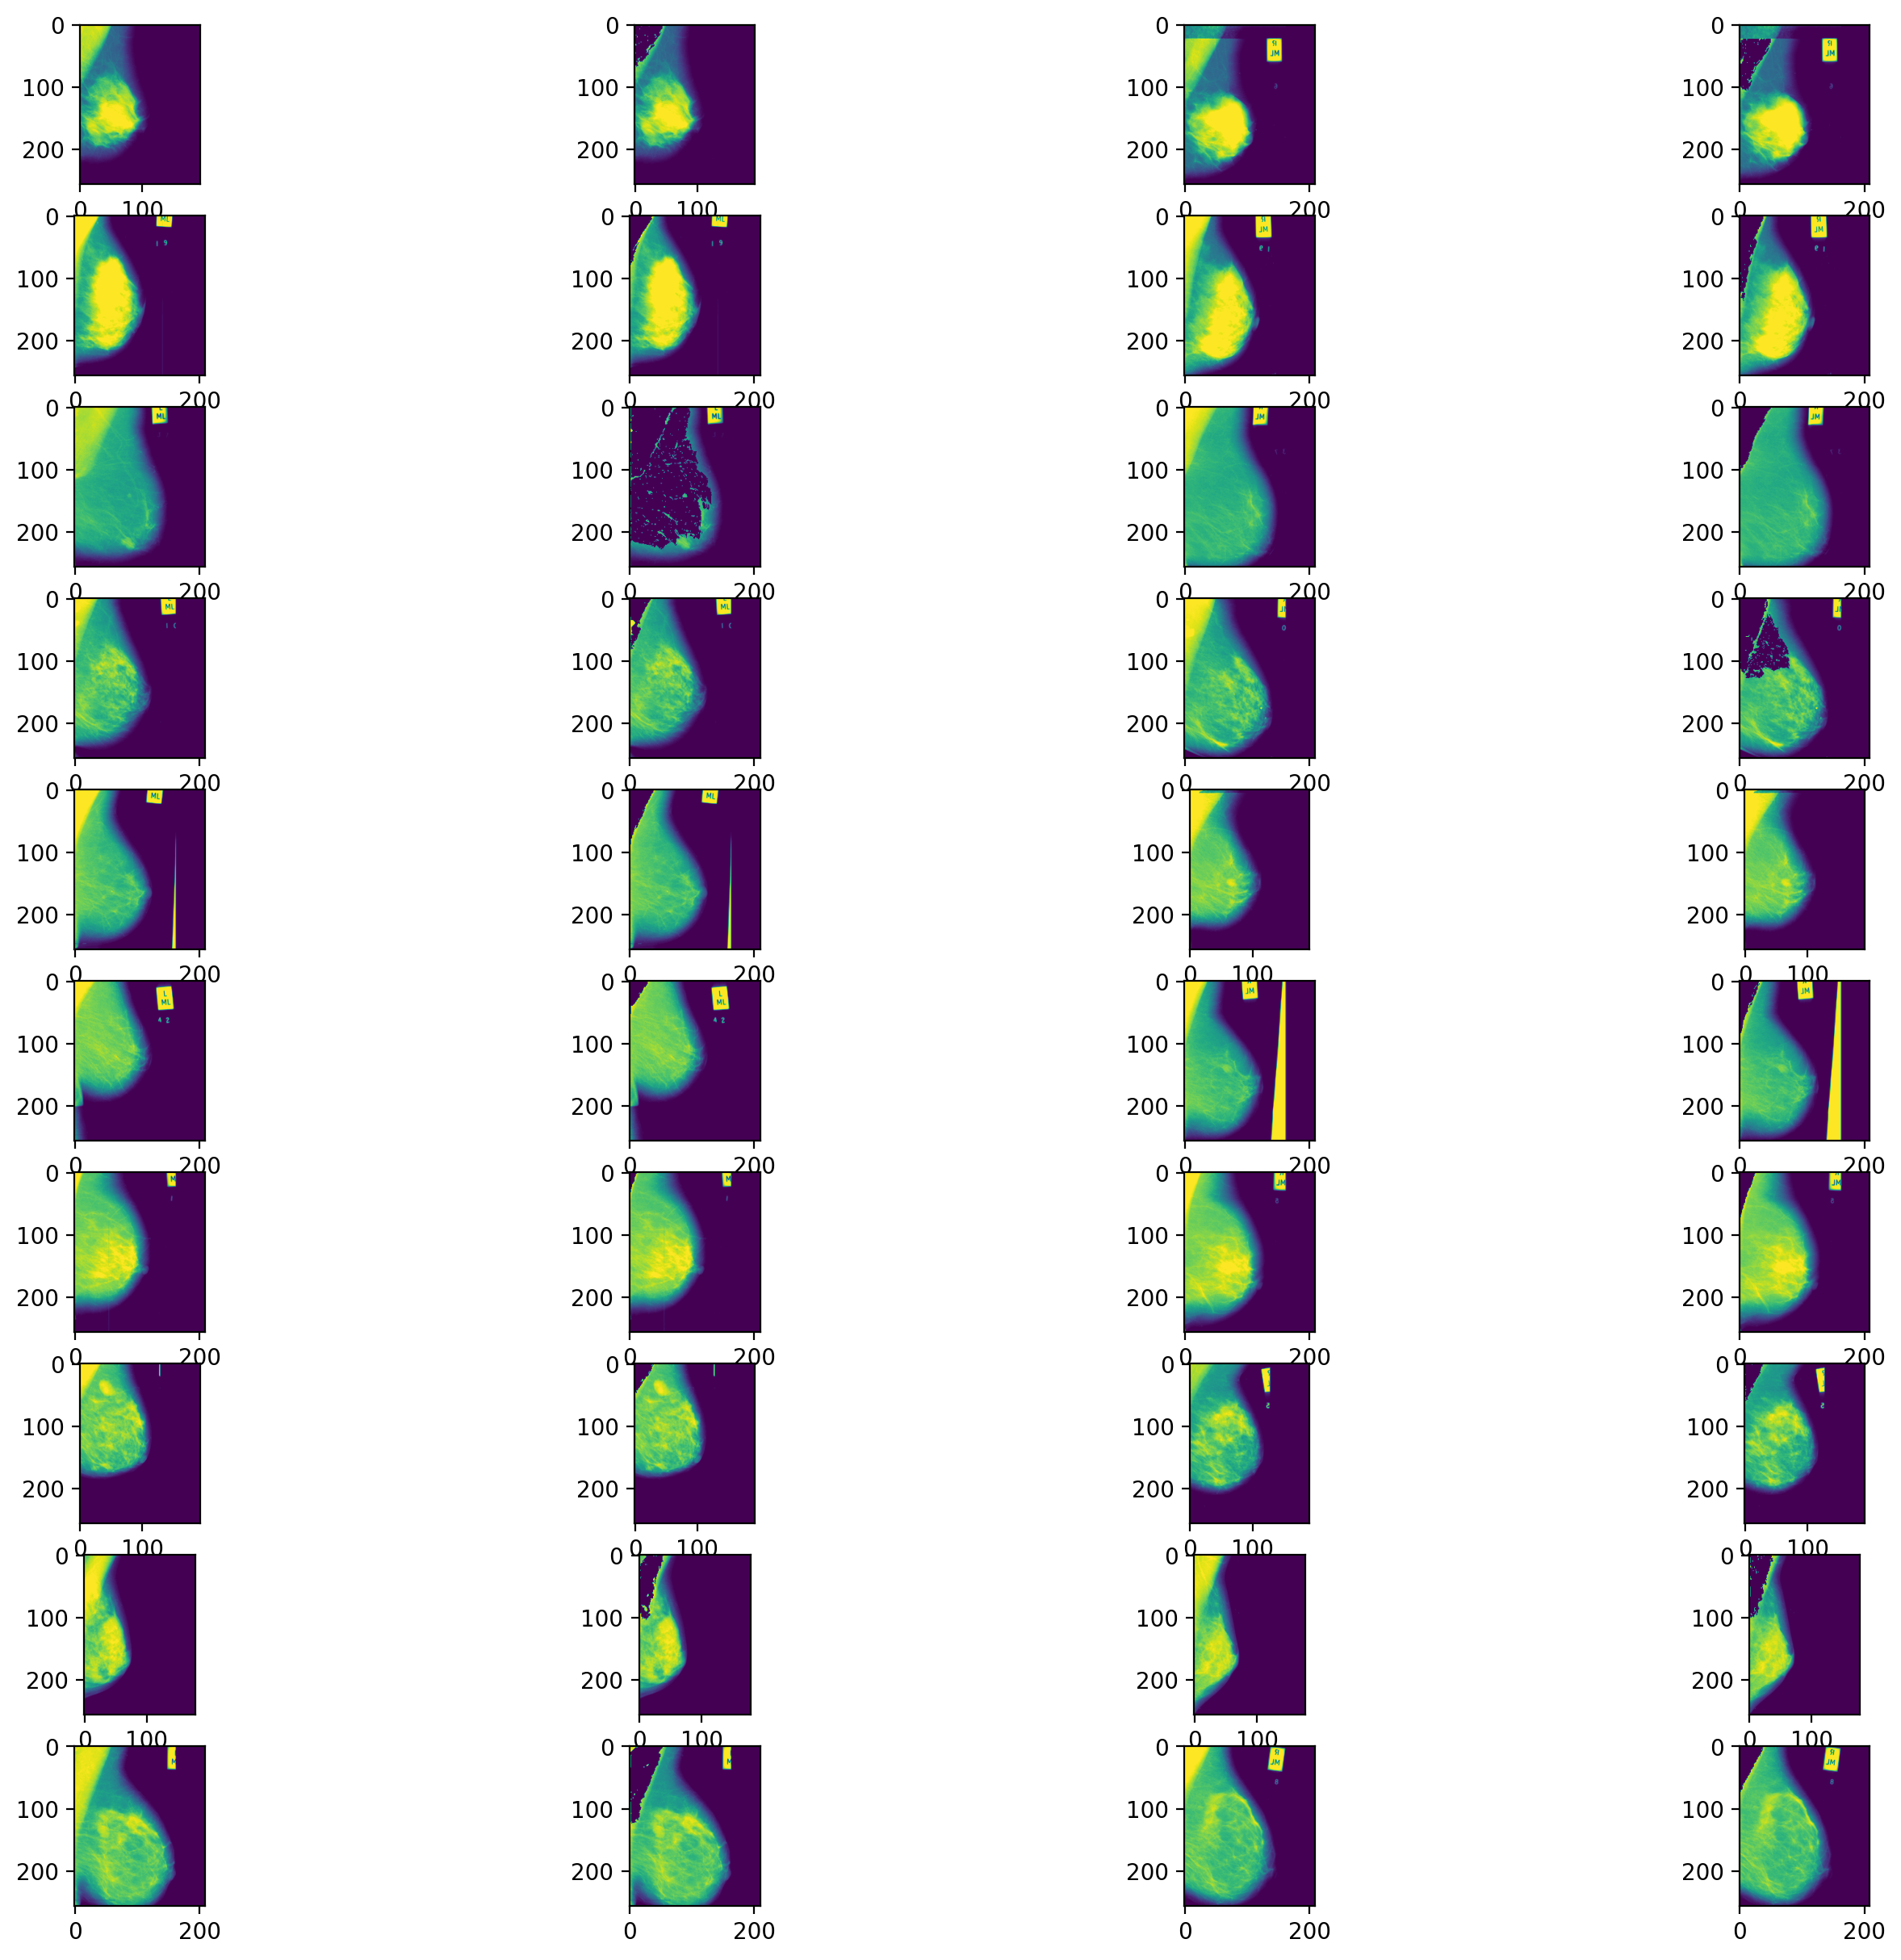

In [11]:
fig = plt.figure(figsize=(17, 17), dpi= 200)
columns = 4
rows = 11
index = 0 
counter = 1

while index < len(original_images):
    fig.add_subplot(rows, columns, counter)
    plt.imshow(original_images[index])
    counter += 1
    fig.add_subplot(rows, columns, counter)
    plt.imshow(modified_images[index])
    counter += 1
    index += 1